# Drifter trajectory forecast

* Dirfter forecast model using model currents

## Practical information

* Install Julia https://julialang.org/downloads/ version 1.0 (or later)
* Install the Julia packages

```julia
using Pkg
Pkg.add("PyPlot")
Pkg.add("NCDatasets")
Pkg.add("Interpolations")
```



Load the Julia modules

In [1]:
using LinearAlgebra
using Statistics
using PyPlot
using NCDatasets
using Interpolations
using Dates



Inspect the variables in the NetCDF 

In [2]:
filename = "med-cmcc-cur-an-fc-hts_1571857899459.nc"
if !isfile(filename)
    download("https://dox.ulg.ac.be/index.php/s/deRlkoJJcBwZdtI/download",filename)
end



Load the necessary variable

In [3]:
ds = Dataset(filename);

lon = nomissing(ds["lon"][:]);
lat = nomissing(ds["lat"][:]);
time = nomissing(ds["time"][:]);
@show time[1]
@show time[end]

u = nomissing(ds["uo"][:,:,1,:],NaN);
v = nomissing(ds["vo"][:,:,1,:],NaN);
close(ds)

time[1] = 2018-10-01T00:30:00
time[end] = 2018-10-31T23:30:00


Land-sea mask for plotting

In [4]:

mask = .!isnan.(u[:,:,1]);

Check sizes of the arrays

In [5]:
@show  size(u)
@show  size(v)
@show  size(lon)
@show  size(lat)
@show  size(time)


size(u) = (145, 145, 744)
size(v) = (145, 145, 744)
size(lon) = (145,)
size(lat) = (145,)
size(time) = (744,)


(744,)

Make a simple plot of the u velocity

In [40]:
"""
Fixes the aspect ratio of a plot.
"""
function set_aspect_ratio()
    ax = gca()
    as = cos(mean([ylim()...]) * pi/180)
    ax.set_aspect(1/as)
    contour(lon,lat,copy(mask'),[0.5],colors="k")
end


set_aspect_ratio

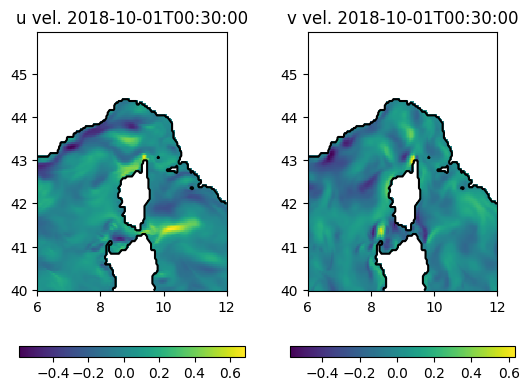

In [41]:
n = 1;
subplot(1,2,1)
pcolor(lon,lat,copy(u[:,:,n]')); colorbar(orientation="horizontal"); 
set_aspect_ratio();
title("u vel. $(time[n])")

subplot(1,2,2)
pcolor(lon,lat,copy(v[:,:,n]')); colorbar(orientation="horizontal"); 
set_aspect_ratio();
title("v vel. $(time[n])");


Plot every 3rd current vector

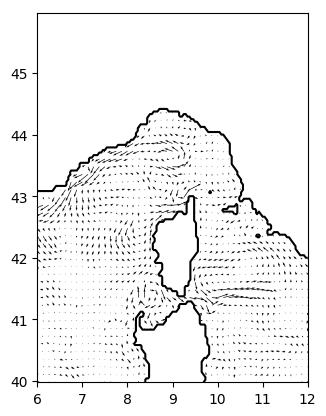

In [42]:
r = 3; 
quiver(lon[1:r:end,1:r:end],lat[1:r:end,1:r:end],copy(u[1:r:end,1:r:end,n]'),copy(v[1:r:end,1:r:end,n]'))
set_aspect_ratio();

In [9]:
function rungekutta4(t,x,dt,f)
  k1 = dt * f(t,x)
  k2 = dt * f(t + dt/2,x + k1/2)
  k3 = dt * f(t + dt/2,x + k2/2)
  k4 = dt * f(t + dt  ,x + k3/2)
  xn = x + k1/6 + k2/3 + k3/3 + k4/6
  return xn
end

function rungekutta2(t,x,dt,f)
  k1 = dt * f(t,x)
  k2 = dt * f(t + dt/2,x + k1/2)
  xn = x + k2
  return xn
end

rungekutta2 (generic function with 1 method)

Be careful to not mix meters and degree.

* 1 degree (latitude) = 110 km
* 1 degree (longitude) = 110 km * cos(latitude * pi/180)


110 km is the earth radius * pi / 180

In [43]:
# seconds since the beginning of the simulation
time_seconds = Dates.value.(time .- time[1]) / (1000);


In [11]:
u_interp = extrapolate(interpolate((lon,lat,time_seconds), u, Gridded(Linear())),NaN);
v_interp = extrapolate(interpolate((lon,lat,time_seconds), v, Gridded(Linear())),NaN);


# Model state vector

For a single drifter, the model state vector is composed by its longitude and latitude

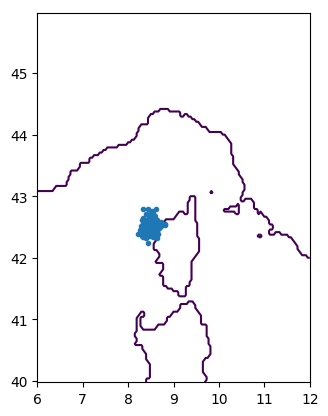

PyObject <matplotlib.contour.QuadContourSet object at 0x7ff7d620fd30>

In [12]:
function f(t,x)    
    lon = x[1]
    lat = x[2]
    
    factoru = 1/(111_000) 
    factorv = 1/(111_000) * cos(lat * pi/180)

    u = u_interp(lon,lat,t) * factoru;
    v = v_interp(lon,lat,t) * factorv;
    return [u, v]
end

dt = 60*60;
Ntimes = round(Int,(30*24*60*60)/dt)
Nparticels = 200
x0 = [8.5, 42.5] .+ 0.1 * randn(2,Nparticels)

plot(x0[1,:],x0[2,:],".")
set_aspect_ratio()

In [13]:
x = zeros(2,Nparticels,Ntimes)
x[:,:,1] = x0
for n = 1:Ntimes-1
    for i = 1:Nparticels
       x[:,i,n+1] = rungekutta4((n-1)*dt,x[:,i,n],dt,f)
    end
end    

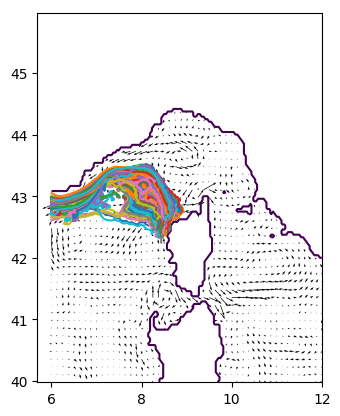

In [14]:
n = 5
r = 3; 
quiver(lon[1:r:end],lat[1:r:end],copy(u[1:r:end,1:r:end,n]'),copy(v[1:r:end,1:r:end,n]'))
set_aspect_ratio()
for i = 1:size(x,2)
  plot(x[1,i,:],x[2,i,:]);
end